<a href="https://colab.research.google.com/github/AliKhalaf1/Ai-assignments/blob/master/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1.Extract The dataset**

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alikhalaf7","key":"475864283a844c65605dd3890fd7a6e1"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:14<00:00, 247MB/s]
100% 2.29G/2.29G [00:14<00:00, 171MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/chest-xray-pneumonia.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

**2.Importing libraries**

In [ ]:
import pandas as pd
import numpy as np
import cv2 as cv
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix

**3.Defining constants**




In [ ]:
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150
BATCH_SIZE = 32


TRAINING_EPOCHS = 30

**4.Extracting Data and preprocessing**

In [ ]:
train_dir = '/content/files/chest_xray/train'
test_dir = '/content/files/chest_xray/test'
val_dir = '/content/files/chest_xray/val'
# val data are only 16 so im not going to use it

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)


In [ ]:
train_data = datagen.flow_from_directory(
        train_dir,
        target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
        batch_size=32,
        class_mode='binary'
        )
test_data = datagen.flow_from_directory(
        test_dir,
        target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
        batch_size=32,
        class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
X_train, y_train = train_data.next()

In [ ]:
print(X_train.shape, y_train.shape)

(32, 150, 150, 3) (32,)


**5.Model**

In [ ]:
mobilenet = tf.keras.applications.MobileNetV2(
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

mobilenet.trainable = False

In [ ]:
inputs = tf.keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

pretrained_model = mobilenet(inputs, training=False)

dense = tf.keras.layers.Dense(1024, activation='relu')(pretrained_model)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)


model = tf.keras.Model(inputs, outputs)


print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense_4 (Dense)             (None, 1024)              1311744   
                                                                 
 dense_5 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 3,570,753
Trainable params: 1,312,769
Non-trainable params: 2,257,984
_________________________________________________________________
None


In [ ]:
earlyStopping =  tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True)

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_data,
    validation_data=test_data,
    batch_size=BATCH_SIZE,
    epochs=TRAINING_EPOCHS,
    callbacks=[earlyStopping]
)

Epoch 1/30
163/163 [==============================] - 89s 527ms/step - loss: 0.2906 - accuracy: 0.9097 - val_loss: 0.8320 - val_accuracy: 0.7308
Epoch 2/30
163/163 [==============================] - 86s 529ms/step - loss: 0.1570 - accuracy: 0.9410 - val_loss: 0.4039 - val_accuracy: 0.8446
Epoch 3/30
163/163 [==============================] - 83s 510ms/step - loss: 0.1278 - accuracy: 0.9488 - val_loss: 0.5014 - val_accuracy: 0.8349
Epoch 4/30
163/163 [==============================] - 78s 477ms/step - loss: 0.1189 - accuracy: 0.9540 - val_loss: 0.2717 - val_accuracy: 0.8974
Epoch 5/30
163/163 [==============================] - 77s 473ms/step - loss: 0.1247 - accuracy: 0.9490 - val_loss: 0.6878 - val_accuracy: 0.7885
Epoch 6/30
163/163 [==============================] - 77s 474ms/step - loss: 0.1079 - accuracy: 0.9592 - val_loss: 0.4216 - val_accuracy: 0.8542
Epoch 7/30
163/163 [==============================] - 76s 466ms/step - loss: 0.1098 - accuracy: 0.9563 - val_loss: 0.3285 - val_ac

**6.Results**

In [ ]:
pred_labels = np.squeeze(np.array(model.predict(test_data) >= 0.5, dtype=np.int))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


In [ ]:
pred_labels

array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,

In [ ]:
test_data.labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

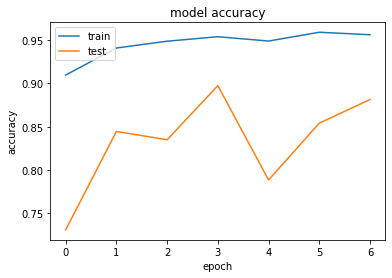

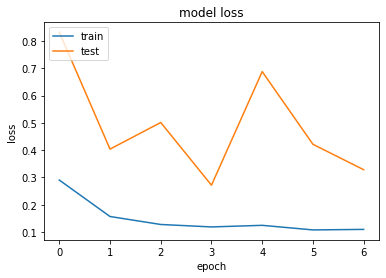

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
cm = confusion_matrix(test_data.labels, pred_labels)

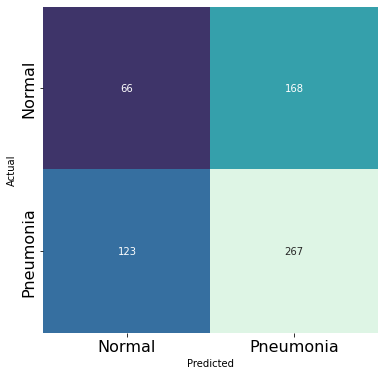

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='mako', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(np.arange(2) + 0.5, ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(np.arange(2) + 0.5, ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [ ]:
results = model.evaluate(test_data, verbose=0)


In [ ]:
results

[0.26599299907684326, 0.8958333134651184]

In [ ]:
accuracy = results[0]
auc = results[1]

In [ ]:
tn, fp, fn, tp = cm.ravel()

precision = tp / (tp + fp)
recall = tp / (tp + fn)

In [ ]:
print("Test loss: {:.2f}".format(accuracy))
print("Auc: {:.2f}".format(auc))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

Test loss: 0.27
Auc: 0.90
Precision: 0.61
Recall: 0.68
